In [31]:
%load_ext autoreload
%autoreload 2

import wandb
import torch
from einops import rearrange
from text3d2video.multiview_features_artifact import MVFeaturesArtifact
from text3d2video.wandb_util import first_used_artifact_of_type
from text3d2video.animation_artifact import AnimationArtifact
from matplotlib import pyplot as plt
from text3d2video.visualization import RgbPcaUtil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
api = wandb.Api()

mv_features = 'deadpool_mv_features:latest'
mv_features = api.artifact(f'romeu/diffusion-3D-features/{mv_features}')
mv_features = MVFeaturesArtifact.from_wandb_artifact(mv_features)

mv_featuers_run = mv_features.wandb_artifact.logged_by()
animation = first_used_artifact_of_type(mv_featuers_run, AnimationArtifact.artifact_type)
animation = AnimationArtifact.from_wandb_artifact(animation)

CommError: artifact 'deadpool_mv_features:latest' not found in 'romeu/diffusion-3D-features'

In [28]:
features_path = mv_features.get_features_path()
files = list(features_path.iterdir())
files[0]

PosixPath('/home/jorge/thesis/artifacts/fox_features:v5/features/layer=level_2&timestep=1&view=0.pt')

In [39]:
feature_id = {'layer':'level_2', 'timestep': 0}
features = [mv_features.get_feature(i, feature_id) for i in mv_features.view_indices()]

TypeError: 'Axes' object is not subscriptable

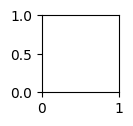

In [37]:
all_features = torch.stack(features)

all_features = rearrange(all_features, 'v c h w -> (v h w) c')
pca = RgbPcaUtil(all_features.shape[1])
pca.fit(all_features)

features_rgb = [pca.feature_map_to_rgb(feature) for feature in features]

cams = mv_features.get_cameras()

N = len(features_rgb)
scale = 1
fig, axs = plt.subplots(1, N, figsize=(scale*N, scale))
for i in range(N):
    axs[i].imshow(features_rgb[i].permute(1,2,0))
    axs[i].axis('off')

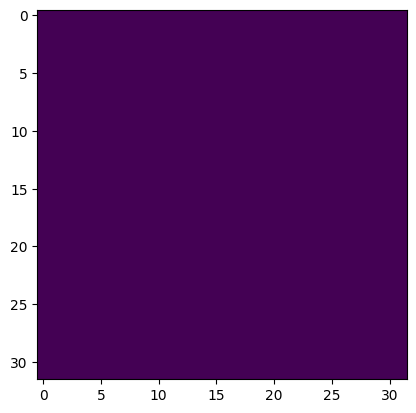

In [141]:
i = 1
greater = features_rgb[i] > 1
lower = features_rgb[i] < 0
both = greater | lower
both = both.any(dim=0)

plt.imshow(both)


In [5]:
from text3d2video.rendering import make_rasterizer, rasterize_vertex_features
from text3d2video.util import project_vertices_to_features

feature_map = features[0]
cam = cams[0]
resolution = feature_map.shape[-1]

vert_features = project_vertices_to_features(mesh, cam, feature_map)

feature_im = rasterize_vertex_features(cams[0], mesh, resolution, vert_features).cpu()

feature_im_rgb = pca.feature_map_to_rgb(feature_im.cpu())
feature_map_rgb = pca.feature_map_to_rgb(feature_map.cpu())

scale = 8
fig, axs = plt.subplots(1, 2, figsize=(scale, scale))
axs[0].imshow(feature_im_rgb.permute(1,2,0))
axs[1].imshow(feature_map_rgb.permute(1,2,0))

for ax in axs:
    ax.axis('off')

fig.tight_layout()

NameError: name 'features' is not defined